In [1]:
import os
import iris
import numpy as np
import xarray as xr
import pandas as pd
import holoviews as hv
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from pathlib import Path


import matplotlib
matplotlib.rcParams.update({'font.size': 15})

In [2]:
def fancy_area(lat_array): 
    '''
    Calculate areas using science instead of g'old brute force
    
    :param lat_arrays np.array: Numpy or panda.Series of latitudes
    
    :returns: Area array in kilometers
    '''
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    # Fancy calulation
    lat_array_radians = lat_array * (np.pi/180)
    areas = (R_earth*dphi)**2 * np.cos(lat_array_radians)
    
    return areas

# Weekly Reanalysis Data - Main (reshape `xarray`)



Using the `xarray` library, let's analyze the reanalysis product. Instead of reshaping (or re-indexing) our data, we will extract the pure values and use `pandas` to pivot everything.

In [40]:
list(Path('../cdsapi_requested_files/').rglob('*.nc'))

[PosixPath('../cdsapi_requested_files/2m_temperature_era5_3hr_2008_01.nc'),
 PosixPath('../cdsapi_requested_files/2m_temperature_era5_3hr_2007_12.nc'),
 PosixPath('../cdsapi_requested_files/2m_temperature_era5_3hr_2008_02.nc')]

In [17]:
era5_netcdf_files = Path('../cdsapi_requested_files/').rglob('*.nc')

list_era_nc_files = []
for reanalysis_month in era5_netcdf_files:
    
    # Load and extract data 
    xarray_data = xr.load_dataset(reanalysis_month) 
    list_extracted_df.append(
        xarray_data
    )

Now that we have a list, we can concatenate the objects on the `time` dimension. Here `xarray` will concat the arrays across time (months in hour case). By using this, we can use the resampling and avoiding future repeated data problems (i.e. month starts in the middle of the week). 

In [49]:
test_combine = xr.auto_combine(list_extracted_df, concat_dim='time')

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 637)
Coordinates:
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * time       (time) datetime64[ns] 2008-01-01 ... 2008-02-29T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 246.05374 ... 223.577

Now thaat we have this, we can resample by week. Since `numpy` needs a monotonic index, we need to order the time array and have dates/hours in order (note that this happens because our files are scrambled). 

In [70]:
test_combine_resample = test_combine.sortby('time').resample(time='1W').mean()
t_df = test_combine_resample.to_dataframe().reset_index(drop=False)

In [71]:
t_df

,latitude,longitude,time,t2m
0,90.0,0.00,2007-12-02,255.999161
1,90.0,0.00,2007-12-09,257.677917
2,90.0,0.00,2007-12-16,254.523102
3,90.0,0.00,2007-12-23,250.647095
4,90.0,0.00,2007-12-30,249.625519
...,...,...,...,...
14535355,-90.0,359.75,2008-02-03,236.261765
14535356,-90.0,359.75,2008-02-10,231.986404
14535357,-90.0,359.75,2008-02-17,236.440323
14535358,-90.0,359.75,2008-02-24,237.549591


### Sanity checks: number of longitudes per latitude

Sometimes things are not what are they suppose to be. 

In [72]:
# Sanity check (pick either 6hr or 12hr, they have the same shape)
# and it's named a because I have lack of imagination
a = a[a.time == '2007-12-02']
a_group = a.groupby(['latitude'], as_index=False).longitude.count()

print(f'The number of longitudes per latitude is: {a_group.longitude.unique()}')

The number of longitudes per latitude is: [1440]


###  _Fancy_ area calculation and temperature buckets (in Kelvin)

In [73]:
# Calculate *fancy* area and get only northern hemisphere ~ México Lindo y Querido!
ds_week_df_times = t_df[t_df.latitude > 20]
ds_week_df_times['area_grid'] = ds_week_df_times.latitude.apply(lambda x: fancy_area(x))

<ipython-input-73-972328fe413a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_week_df_times['area_grid'] = ds_week_df_times.latitude.apply(lambda x: fancy_area(x))


In [74]:
# Make cut-offs with 12-hours (more spread)
cut_off = pd.interval_range(start=int(min(ds_week_df_times.t2m)), 
                            end=int(max(ds_week_df_times.t2m)) + 5, 
                            freq=5)

ds_week_df_times = ds_week_df_times.assign(temp_bracket=pd.cut(ds_week_df_times['t2m'], 
                                                               cut_off, 
                                                               right=True))

In [76]:
ds_week_df_times

,latitude,longitude,time,t2m,area_grid,temp_bracket
0,90.00,0.00,2007-12-02,255.999161,4.726606e-14,"(251, 256]"
1,90.00,0.00,2007-12-09,257.677917,4.726606e-14,"(256, 261]"
2,90.00,0.00,2007-12-16,254.523102,4.726606e-14,"(251, 256]"
3,90.00,0.00,2007-12-23,250.647095,4.726606e-14,"(246, 251]"
4,90.00,0.00,2007-12-30,249.625519,4.726606e-14,"(246, 251]"
...,...,...,...,...,...,...
5644795,20.25,359.75,2008-02-03,289.989410,7.242024e+02,"(286, 291]"
5644796,20.25,359.75,2008-02-10,293.872620,7.242024e+02,"(291, 296]"
5644797,20.25,359.75,2008-02-17,296.124298,7.242024e+02,"(296, 301]"
5644798,20.25,359.75,2008-02-24,294.182831,7.242024e+02,"(291, 296]"


In [91]:
# Save data for Amanda
ds_week_df_times.to_csv('t2m_temp_1207_0208.csv',index=False)

In [80]:
# Calculate count of grids per group: time and temperature range
ds_week_df_north_group = ds_week_df_times.\
groupby(['temp_bracket', 'time'], as_index=False)[['latitude']].\
count().\
rename(columns = {'latitude': 'number_grids'})

ds_week_df_north_group = ds_week_df_north_group.assign(
    number_grids_cumsum = ds_week_df_north_group.number_grids.cumsum(),
    left_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group.temp_bracket.apply(lambda x: x.right)
)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


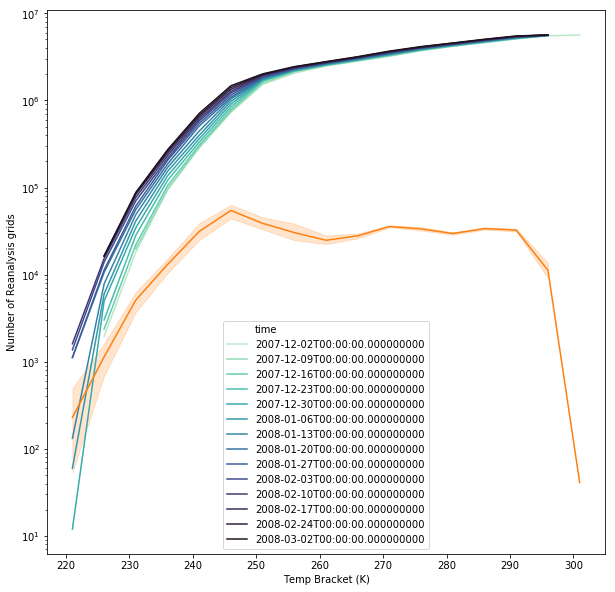

In [81]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="number_grids_cumsum", 
             hue='time',
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group)
sns.lineplot(x="left_temp_interval", 
             y="number_grids",
             palette=sns.color_palette("BuGn", 14),
             data=ds_week_df_north_group,
             ax=ax,
             legend=False)
ax.set(xlabel='Temp Bracket (K)', ylabel='Number of Reanalysis grids')
plt.yscale('log')

###  Calculate weekly temperature bucket covered area in the northern hemisphere [$latitude > 20$]

In [84]:
# Calculate sum of grid area per group: time and temperature range
ds_week_df_north_group_area = ds_week_df_times.\
groupby(['temp_bracket', 'time'], as_index=False)['area_grid'].\
sum().\
rename(columns = {'area_grid': 'total_area_grid'})

# There must be a better way of doing this (maybe .agg method?)
ds_week_df_north_group_area['grids_cumsum_area'] = ds_week_df_north_group_area.\
groupby('time').\
total_area_grid.\
cumsum()

ds_week_df_north_group_area = ds_week_df_north_group_area.assign(
    left_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.left),
    right_temp_interval = ds_week_df_north_group_area.temp_bracket.apply(lambda x: x.right)
)

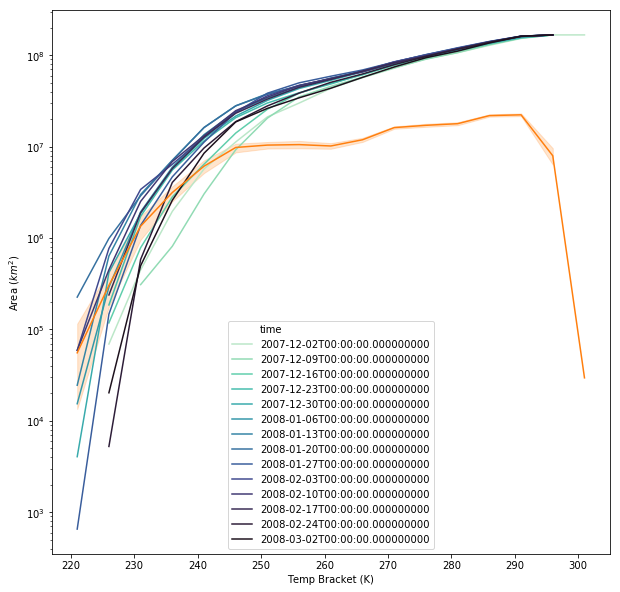

In [85]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="grids_cumsum_area", 
             hue='time',
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area)
sns.lineplot(x="left_temp_interval", 
             y="total_area_grid",
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area,
             ax=ax)
ax.set(xlabel='Temp Bracket (K)', ylabel=r'Area ($km^{2}$)')
plt.yscale('log')

### Calculate effective latitude using math!

We can calculate the effective $(\varphi)$ latitude using the following formula:
$$
Area = 2 \pi r^{2} (1 - sin( \varphi) )
$$

From this we can rearange the equation to get: 

$$
1 - \frac{A}{2\pi r^{2}} = arcsin(\varphi)
$$

In [86]:
def eff_latitude(cdf_areas):
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    pdf_lat_effs =  np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    
    return pdf_lat_effs

In [87]:
ds_week_df_north_group_area = ds_week_df_north_group_area.assign(
    eff_lat = ds_week_df_north_group_area.grids_cumsum_area.apply(lambda x: eff_latitude(x))
) 

ds_week_df_north_group_area['eff_lat_cumsum'] = ds_week_df_north_group_area.\
groupby('time').\
eff_lat.\
fillna(0).\
cumsum(skipna=False)

/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/seaborn/algorithms.py:70: RuntimeWarning: Mean of empty slice.
  return getattr(x, func)()
/Users/topcat/.pyenv/versions/miniconda3-latest/envs/reanalysis_env/lib/python3.8/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[Text(0,0.5,'Effective Latitude [$\\varphi$] (radians)'),
 Text(0.5,0,'Temp Bracket (K)')]

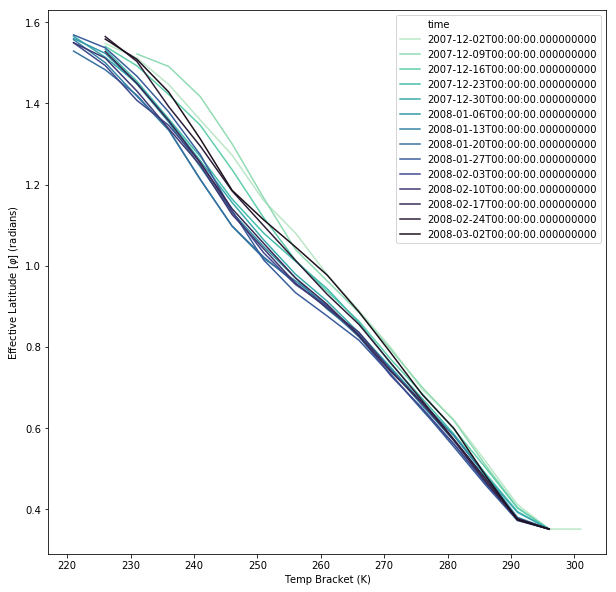

In [92]:
fig, ax = plt.subplots(figsize = (10, 10))
sns.lineplot(x="left_temp_interval", 
             y="eff_lat", 
             hue='time', 
             palette=sns.color_palette("mako_r", 14),
             data=ds_week_df_north_group_area)
ax.set(xlabel="Temp Bracket (K)", ylabel=r'Effective Latitude [$\varphi$] (radians)')

<h3><center>Amanda's Test (and data comparison: 12 hr vs 6-hr)!</center></h3>

In [280]:
# Create subset data and equal cuts
test = ds_week_df_north[ds_week_df_north.time == '2007-12-02'].\
groupby('temp_bracket', as_index=False)['area_grid'].\
sum()

test['area_cumsum'] = test.area_grid.fillna(0).cumsum(skipna=False)
print(test)

   temp_bracket     area_grid   area_cumsum
0    (220, 225]  0.000000e+00  0.000000e+00
1    (225, 230]  7.376136e+03  7.376136e+03
2    (230, 235]  8.638108e+04  9.375721e+04
3    (235, 240]  3.701555e+05  4.639127e+05
4    (240, 245]  1.180695e+06  1.644608e+06
5    (245, 250]  1.889900e+06  3.534508e+06
6    (250, 255]  3.485017e+06  7.019525e+06
7    (255, 260]  3.690253e+06  1.070978e+07
8    (260, 265]  5.475165e+06  1.618494e+07
9    (265, 270]  6.208379e+06  2.239332e+07
10   (270, 275]  6.490670e+06  2.888399e+07
11   (275, 280]  1.058930e+07  3.947329e+07
12   (280, 285]  9.756696e+06  4.922999e+07
13   (285, 290]  1.315170e+07  6.238168e+07
14   (290, 295]  1.763785e+07  8.001954e+07
15   (295, 300]  1.447008e+07  9.448961e+07
16   (300, 305]  2.982336e+05  9.478785e+07


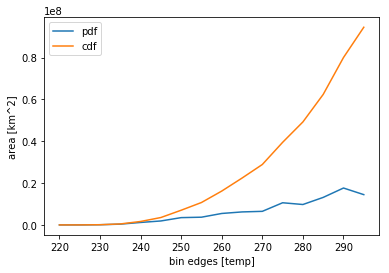

In [339]:
def plots(binedges,pdf,cdf,ylab):
    plt.plot(binedges,pdf,label='pdf')
    plt.plot(binedges,cdf,label='cdf')
    plt.xlabel('bin edges [temp]')
    plt.ylabel(ylab)
    plt.legend()
    plt.show()

def dists_of_areas(temp_df,lat,plot=False):
    #weight entry by box area so that y axis is no longer the number of boxes, but rather the area taken up by each box
    #lat = air_df['lat'][air_df['lat']>20]*np.pi/180. #np.linspace(np.pi/2.,np.pi/2.*(1-1/4.),num=100)
    #this is the area of each grid cell
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    # This is hardcoded!
    Tbins = range(int(ds_week_df_north.t2m.min()),int(ds_week_df_north.t2m.max()), 5)
    #Amanda's bins!
    #Tbins = range(218, 311, 5)
    
    #Function starts here
    lat_rad = lat * (np.pi/180)
    
    areas = (R_earth*dphi)**2 * np.cos(lat_rad)
    pdf_areas, binedges = np.histogram(temp_df,bins=Tbins,weights=areas)
    cdf_areas=np.cumsum(pdf_areas)
    if plot:
        plots(binedges[:-1],pdf_areas,cdf_areas,'area [km^2]')

    return binedges[:-1], pdf_areas, cdf_areas

# Create subset data and equal cuts
ds_week_df_north = ds_week_df[ds_week_df.latitude > 20].reset_index(drop=False)
Tbins = range(int(ds_week_df_north.t2m.min()),int(ds_week_df_north.t2m.max()), 5)

test = ds_week_df_north[(ds_week_df_north.time == '2007-12-02')]

binedgs, pdf_area,cdf_area = dists_of_areas(test.t2m, test.latitude, plot=True)

In [340]:
print(
pd.DataFrame({'bins': binedgs,
            'pdf_area': pdf_area,
            'cdf_area': cdf_area})
)

    bins      pdf_area      cdf_area
0    220  0.000000e+00  0.000000e+00
1    225  7.376136e+03  7.376136e+03
2    230  8.638108e+04  9.375721e+04
3    235  3.701555e+05  4.639127e+05
4    240  1.180695e+06  1.644608e+06
5    245  1.889900e+06  3.534508e+06
6    250  3.485017e+06  7.019525e+06
7    255  3.689987e+06  1.070951e+07
8    260  5.472930e+06  1.618244e+07
9    265  6.210646e+06  2.239309e+07
10   270  6.489771e+06  2.888286e+07
11   275  1.058990e+07  3.947276e+07
12   280  9.756025e+06  4.922878e+07
13   285  1.315222e+07  6.238100e+07
14   290  1.763505e+07  8.001605e+07
15   295  1.447356e+07  9.448961e+07


In [ ]:
array([0.00000000e+00, 1.24345111e+03, 4.52785594e+04, 2.52375020e+05,
       1.09955965e+06, 2.70551112e+06, 5.41877087e+06, 9.25519620e+06,
       1.36094762e+07, 1.97595232e+07, 2.59713011e+07, 3.53327313e+07,
       4.55785077e+07, 5.54954993e+07, 7.28509067e+07, 9.04430135e+07,
       9.47878486e+07, 9.47878486e+07])

In [284]:
def dists_of_lat_eff(cdf_areas,binedges=None,plot=False):
    """if plot is set to true, must specify binedges"""
    #A = 2piR^2 (1-sin(lat_eff))
    #so 1-A/(2piR^2) = sin(lat_eff)
    #but remember latitude is defined to start at pi at the north pole
    
    # ERA-5 Parameters
    R_earth = 6367.47 #km
    dphi = (0.25 * np.pi) / 180. #radians, this is also dlambda
    
    pdf_lat_effs = np.pi/2.-np.arccos(1-cdf_areas / (2*np.pi*R_earth**2) )
    cdf_lat_effs = np.cumsum(pdf_lat_effs)
    if plot:
        plots(binedges,pdf_lat_effs,pdf_lat_effs,'effective lat')
    return pdf_lat_effs, cdf_lat_effs

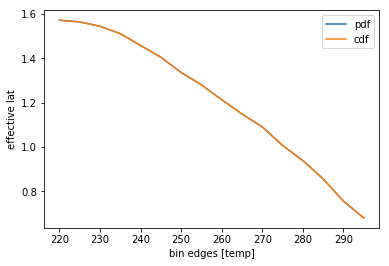

(array([1.57079633, 1.56318652, 1.54366483, 1.5104373 , 1.45710608,
        1.40402321, 1.33550045, 1.2798075 , 1.21244715, 1.14837194,
        1.08999068, 1.00666388, 0.93864175, 0.85584975, 0.75584424,
        0.68037995]),
 array([ 1.57079633,  3.13398285,  4.67764767,  6.18808497,  7.64519105,
         9.04921426, 10.38471471, 11.66452221, 12.87696936, 14.0253413 ,
        15.11533197, 16.12199586, 17.0606376 , 17.91648736, 18.67233159,
        19.35271154]))

In [285]:
dists_of_lat_eff(cdf_area,binedges=binedgs,plot=True)